# Bayesian Multilevel Modelling using PyStan

This is a tutorial, following through Chris Fonnesbeck's [primer on using PyStan with Bayesian Multilevel Modelling](http://mc-stan.org/documentation/case-studies/radon.html).

# 9. Partial Pooling - Varying Slope

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import seaborn as sns

import clean_data
import pooled_model
import unpooled_model

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Teaching/Teaching-Stan-Hierarchical-Modelling/venv-Teaching-Stan-Hierarchical/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0ac21a09143e1678f06ad0a8c64d4c81 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_56b08b63d48247e5e31d7c6f26b156c8 NOW.


## Partial pooling: varying intercept

We can also extend partial pooling to a linear model of the relationship between measured log(radon), the prevailing state radon level, and the effect of the floor at which the measurement was made, *where the county affects the effect of making the measurement at different floors*. In this linear model, the measured radon level in a household $y_i$ is a function of the floor at which measurement took place, $x_i$, with parameters $\alpha$ (the prevailing radon level in the state) and $\beta_{j[i]}$ (the influence of the floor, which varies by county), and residual error $\epsilon_i$.

$$y_i = \alpha + \beta_{j[i]} x_i + \epsilon_i$$

In this linear model, the floor effect $\beta_{j[i]}$ is the slope, with random Normal effect:

$$\beta_{j[i]} \sim N(\mu_{\beta}, \sigma_{\beta}^2)$$

The residual error is also sampled from a Normal distribution:

$$\epsilon_i \sim N(0, \sigma_y^2)$$

As in the previous example, varying intercept, the multilevel modelling approach allows parameter distributions - *information* to be *shared* across groups, which can lead to more reasonable estimates of parameters with relatively little data. 

### Specifying the model

We define the model in `stan`, as usual specifying `data`, `parameters`, `transformed parameters` and `model` blocks. The model is built up as follows.

Our observed log(radon) measurements ($y$) approximate an intermediate transformed parameter $\hat{y}$, which is normally distributed with variance $\sigma_y^2$. $\sigma_y$ is sampled from a Uniform distribution.

$$y \sim N(\hat{y}, \sigma_y^2)$$
$$\sigma_{y} \sim U(0, 100)$$

The transformed variable $\hat{y}$ is a linear function of $x_i$, the floor at which radon is measured. The parameters are the value of $\alpha$ across the whole state, and the effect due to which floor is used for measurement, and this is associated with the county $i$ ($i=1,\ldots,N$) in which each household is found.

$$\hat{y_i} = {\alpha + \beta_{j[i]} x_i}$$

The value of $\beta$ for each county $j[i]$, is Normally distributed with mean $\mu_{\beta}$ and variance $\sigma_{\beta}^2$. $\sigma_{\beta}$ is sampled from a Uniform distribution, between 0 and 100. $\mu_{\beta}$ is an unconstrained real value. There is a common mean and variance underlying each of the floor effects for each county.

$$\beta_{j[i]} \sim N(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\sigma_{\beta} \sim U(0, 100)$$

The value of $\alpha$ is assumed to be Normally distributed about zero, with unit variance:

$$\alpha \sim N(0, 1)$$


In `data`:
* `J` is the number of counties (`int`)
* `N` is the number of samples (`int`)
* `county` is a list of `N` values from 1-85, specifying the county index each measurement
* `x` is a `vector` of indices for which floor the radon measurements were taken at each household
* `y` is a `vector` of log(radon) measurements, one per household/sample.

We define parameters:

* `a` (`real`) representing $\alpha$, the prevailing state-wide radon level
* `b` (`vector`, one value per county), representing $\beta$, the vector of floor effects for each county.
* `mu_b`, a `real` corresponding to $\mu_{\beta}$, the mean floor effect underlying the distribution from which the county levels are drawn.
* `sigma_b` is $\sigma_{\beta}$, the standard deviation of the floor effect distribution underlying the county level effects: variability of county means about the average.
* `sigma_y` is $\sigma_y$, the standard deviation of the measurement/sampling error: residual error of the observations.

In [2]:
varying_slope = """
data {
  int<lower=0> J;
  int<lower=0> N;
  int<lower=1,upper=J> county[N];
  vector[N] x;
  vector[N] y;
}
parameters{
  real a;
  vector[J] b;
  real mu_b;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_y;
}
transformed parameters {
  vector[N] y_hat;
  for(i in 1:N)
    y_hat[i] <- a + x[i] * b[county[i]];
}
model {
  sigma_b ~ uniform(0, 100);
  b ~ normal(mu_b, sigma_b);
  
  a ~ normal(0, 1);
  
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

### Fitting the model

Again, we map Python variables to those in the model, and run the fit:

In [3]:
n_county = clean_data.srrs_mn.groupby('county')['idnum'].count()  # number of samples from each county

varying_slope_data = {'N': len(clean_data.log_radon),
                      'J': len(n_county),
                      'county': clean_data.county + 1,
                      'x': clean_data.floor_measure,
                      'y': clean_data.log_radon}

varying_slope_fit = pystan.stan(model_code=varying_slope,
                                data=varying_slope_data,
                                iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_27f02fca7ab4b4f43493a52bdabc90a1 NOW.


We can then collect the county-level estimates of floor effect, the *slope* of the model, $\beta_{j[i]}$, from `b` (1000 iterations x 85 counties):

In [4]:
b_sample = pd.DataFrame(varying_slope_fit['b'])

## Interpreting the model output

We can visualise the distribution of these estimates, by county, with a boxplot:

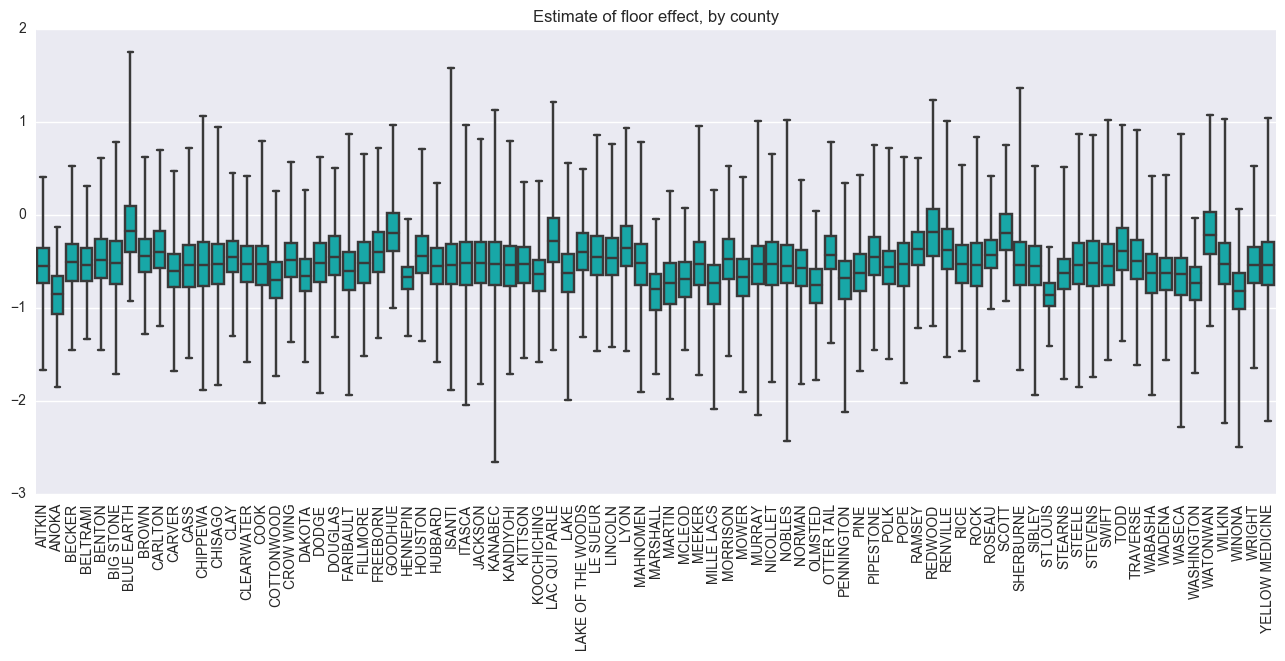

In [5]:
# Boxplot of estimated floor effect by county
plt.figure(figsize=(16, 6))
g = sns.boxplot(data=b_sample, whis=np.inf, color="c")
g.set_xticklabels(clean_data.mn_counties, rotation=90)  # label counties
g.set_title("Estimate of floor effect, by county")
g;

From this plot we can see that the estimate for $\beta$ is approximately -0.6 in almost all counties, and there is very little variation in the median estimate, though the range of uncertainty is, as before, greatest in the counties with fewest households, and least in the counties with the most households.

We can plot the linear relationships by county, to see how the fitted model estimates of slope vary:

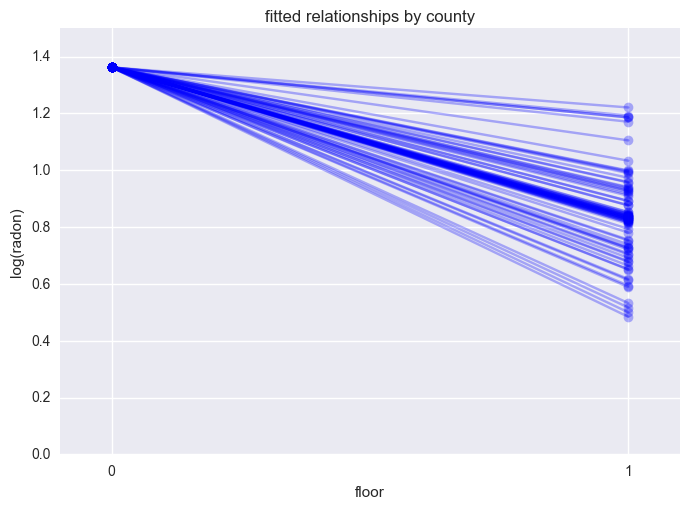

In [6]:
xvals = np.arange(2)  # floor
bp = varying_slope_fit['a'].mean()         # mean a (intercept) across state
mp = varying_slope_fit['b'].mean(axis=0)   # mean b (slope/floor effect) by county
for mi in mp:
    plt.plot(xvals, mi * xvals + bp, 'bo-', alpha=0.3)
plt.xticks([0, 1])
plt.xlim(-0.1, 1.1)
plt.ylim(0, 1.5)
plt.title("fitted relationships by county")
plt.xlabel("floor")
plt.ylabel("log(radon)");

It is clear from this plot that we have fitted the same prevailing radon level to each county, but with a different floor effect in each county. There are four or five counties with smaller floor effects, but the bulk of counties form a set of similar fits.